In [1]:
using Revise
using NonEquilibriumGreenFunction
using HssMatrices
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using BenchmarkTools
#HSS compression does not leverage efficiently the BLAS multithreading. 
#It is better to turn it off
BLAS.set_num_threads(1)

In [2]:
module Junction
using Revise
using Symbolics
using NonEquilibriumGreenFunction
using LinearAlgebra
struct Parameters
    δt::Float64 #timestep
    T::Float64  #simulation length
    Γl::Float64 #left tunneling rate
    Γr::Float64 #right tunneling rate
    β::Float64  #inverse temperature
    ϕl # left phase
    ϕr # right phase
end
default_compression() = HssCompression(leafsize=32)
function Parameters(; δt, T, Γl=1, Γr=1, β=1, ϕl, ϕr)
    return Parameters(δt, T, Γl, Γr, β, ϕl, ϕr)
end
axis(p::Parameters) = 0:p.δt:p.T
function simulate_junction(p::Parameters; cpr=default_compression())
    #retarded
    Σ_R_right = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γr, compression=cpr)
    Σ_R_left = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γl, compression=cpr)
    Σ_R = Σ_R_left + Σ_R_right
    g = discretize_retardedkernel(axis(p), (t, tp) -> ComplexF64(-1im), compression=cpr, stationary=true)
    G_R = solve_dyson(g, g * Σ_R)
    #kinetic 
    ρ = discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) .|> ComplexF64,
        stationary=true, compression=cpr)
    coupling_left = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γl) * exp(1im * p.ϕl(t) / 2), compression=cpr)
    coupling_right = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γr) * exp(1im * p.ϕr(t) / 2), compression=cpr)
    Σ_K_left = -2im*coupling_left' * ρ * coupling_left
    Σ_K_right = -2im*coupling_right' * ρ * coupling_right
    Σ_K = Σ_K_left + Σ_K_right
    G_K = G_R * Σ_K * G_R'
    return (; G_R, G_K, Σ_R_left, Σ_K_left, Σ_R_right, Σ_K_right)
end
function compute_average_current(results)
    #First we build the expression
    @variables G_R::Kernel G_K::Kernel
    @variables Σ_R::Kernel Σ_K::Kernel
    τz = [1 2; 2 3] // 2
    G = [0 G_R'; G_R G_K]
    Σl = [Σ_K Σ_R; Σ_R' 0]
    expr = simplify_kernel(tr(τz * (G * Σl - Σl * G)))
    #convert to a julia expression and compile
    f = build_function(expr, G_R, G_K, Σ_R, Σ_K, expression=Val{false})
    #evaluate it
    I_avr_op = f(results[:G_R], results[:G_K], results[:Σ_R_left], results[:Σ_K_left])
    #We just have to take the diagonal elements. 
    diag(matrix(I_avr_op))
end
end

Main.Junction

# Equilibrium simulation

In [3]:
p = Junction.Parameters(δt=0.1, T=100, ϕl=t -> 0, ϕr=t -> 1);
println("N = $(Junction.axis(p)|> length)")
results = Junction.simulate_junction(p, cpr=HssCompression());

N = 1001


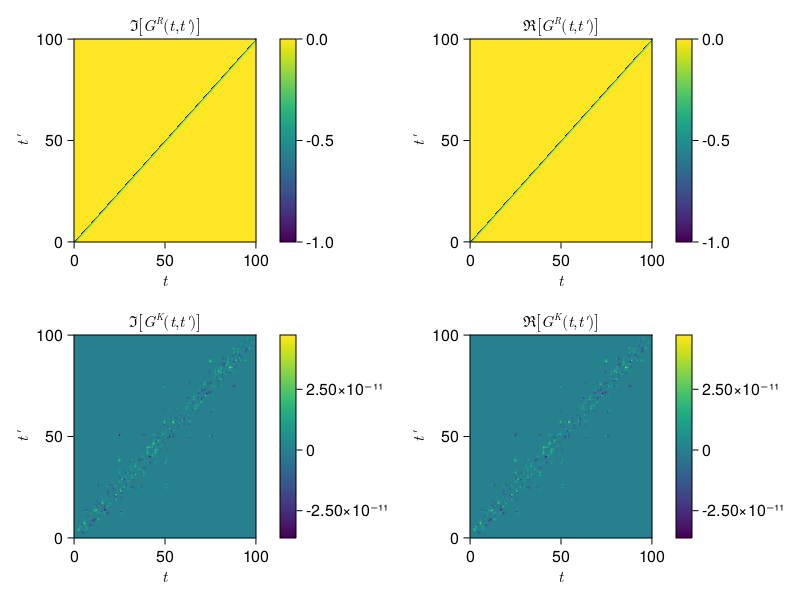

In [4]:
function plot_results_maps(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title=L" \Im \left[ G^R(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_R = matrix(results[:G_R]) |> full
    ax = Junction.axis(p) |> collect
    im_G_R = imag.(G_R)
    hm = heatmap!(f_ax, ax, ax, im_G_R)
    Colorbar(f[1, 2], hm)
    f_ax = Axis(f[1, 3], title=L"\Re \left[ G^R(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_R = real.(G_R)
    hm = heatmap!(f_ax, ax, ax, im_G_R)
    Colorbar(f[1, 4], hm)
    #Keldysh Green function
    f_ax = Axis(f[2, 1], title=L" \Im \left[ G^K(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    G_K = matrix(results[:G_K]) |> full
    ax = Junction.axis(p) |> collect
    im_G_K = imag.(G_K)
    hm = heatmap!(f_ax, ax, ax, im_G_K)
    Colorbar(f[2, 2], hm)
    f_ax = Axis(f[2, 3], title=L"\Re \left[ G^K(t,t')\right]", xlabel=L"t", ylabel=L"t'")
    re_G_K = real.(G_K)
    hm = heatmap!(f_ax, ax, ax, im_G_K)
    Colorbar(f[2, 4], hm)

    f
end
#We do not want to plot the full map for large simulation. 
#It would blow up the memory. 
if length(Junction.axis(p)) < 2001
    plot_results_maps(results)
end

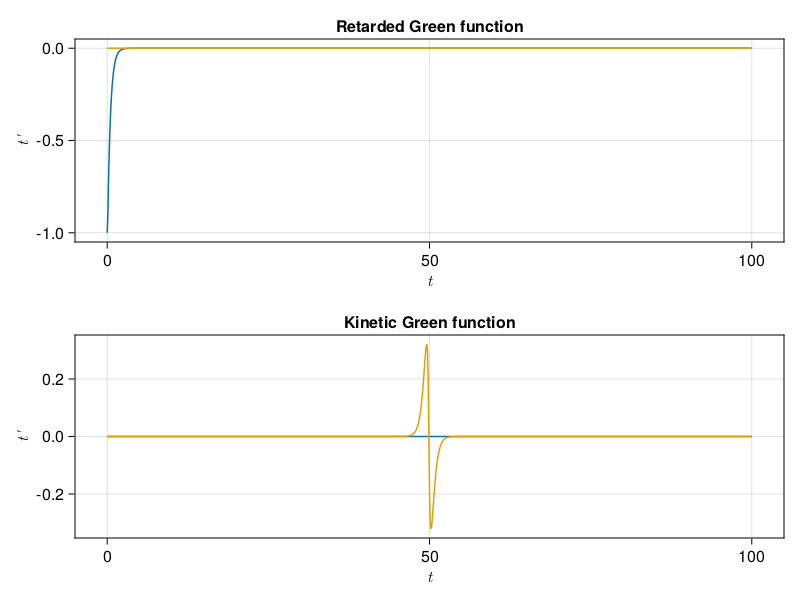

In [5]:
function plot_results(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title="Retarded Green function", xlabel=L"t", ylabel=L"t'")
    G_R = results[:G_R]
    ax = Junction.axis(p) |> collect
    im_G_R = reshape(imag.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, im_G_R)
    re_G_R = reshape(real.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, re_G_R)
    #Keldysh Green function
    G_K = results[:G_K]
    ax = Junction.axis(p) |> collect
    im_G_K = reshape(imag.(vcat(discretization(G_K)[:, length(ax)÷2]...)), :)
    f_ax = Axis(f[2, 1], title="Kinetic Green function", xlabel=L"t", ylabel=L"t'")
    lines!(f_ax, ax, im_G_K)
    re_G_K = reshape(real.(vcat(discretization(G_K)[:, length(ax)÷2]...)), :)
    lines!(f_ax, ax, re_G_K)
    f
end
plot_results(results)

## Benchmarks 
We benchmark the full resolution increasing simulation length, including the initial construction of the different kernels. 
To get out of equilibrium and make things more interesting, we add a small bias voltage.

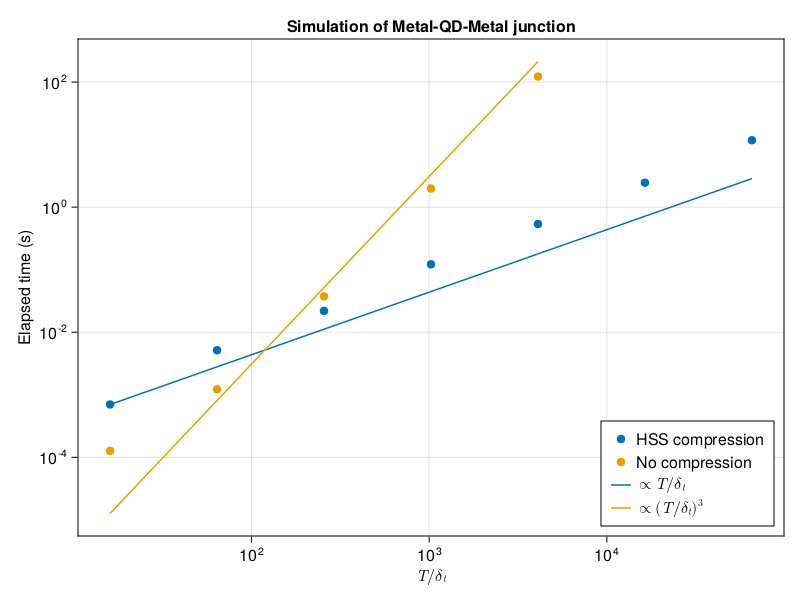

In [6]:

tab_T_hss = p.δt .* [2^k for k = 4:2:16]
function benchmark_equilibrium_hss(T)
p = Junction.Parameters(δt=0.1, T=T, ϕl=t -> 0, ϕr=t -> 0.1*t);
    @benchmark Junction.simulate_junction($p);
end
benchmark_equilibrium_results_hss = benchmark_equilibrium_hss.(tab_T_hss)

tab_T_full = p.δt .* [2^k for k = 4:2:12]
function benchmark_equilibrium_full(T)
    p = Junction.Parameters(δt=0.1, T=T, ϕl=t -> 0, ϕr=t -> 0.1*t);
    @benchmark Junction.simulate_junction($p,cpr = NONCompression());
end
benchmark_equilibrium_results_full = benchmark_equilibrium_full.(tab_T_full)

function plot_equilibrim_benchmark(tab_T_hss, results_hss, tab_T_full, results_full)
    f = Figure()
    f_ax = Axis(f[1, 1], xscale = log10, yscale = log10,
    title = "Simulation of Metal-QD-Metal junction",
    xlabel=L"T/\delta_t",
    ylabel="Elapsed time (s)")
    scatter!(f_ax, tab_T_hss / p.δt, map(results_hss) do x
        median(x.times) * 1E-9
    end,
    label = "HSS compression"
    )
    scatter!(f_ax, tab_T_full / p.δt, map(results_full) do x
        median(x.times) * 1E-9
    end,
    label = "No compression"
    )
    lines!(f_ax,tab_T_hss / p.δt, tab_T_hss ./ tab_T_hss[1] .* median(results_hss[1].times) * 1E-9, 
    label = L"\propto T/\delta_t"  )
    lines!(f_ax,tab_T_full / p.δt , tab_T_full.^3 ./ tab_T_full[1]^3 .* median(results_full[1].times) * 1E-10,
    label = L"\propto (T/\delta_t)^3"  )
    axislegend(position = :rb)
    f
end
f = plot_equilibrim_benchmark(
    tab_T_hss,
    benchmark_equilibrium_results_hss,
    tab_T_full,
    benchmark_equilibrium_results_full
)
save("QD_benchmark.svg",f)
f

## Voltage biased junctions 
When a voltage biased is applied accross a junction, a current appears.

When biasing an interface with a tension $U_l(t)$, the tunnel coupling phases evolve according to
\begin{equation}
 \frac{\text{d}\phi_l(t)}{dt} = \frac{2e}{\hbar}U_l(t)
\end{equation}

The average current from the lead $l$ is: 
\begin{equation}
    	\left \langle I_l(t) \right \rangle 
		= \frac{e}{ 2 \hbar} \text{tr}^{K}\left\{\tau_z
		\int
		G(t,\tau) \Sigma_l(\tau,t) 
		- \Sigma_l(t,\tau)G(\tau,t) \text{d} \tau 
		 \right\} 
\end{equation}
Where $\Sigma_l$ is the self energy associated to lead $l$ and $G$ is the full Green function of the dot. $\tau_z$ is third Pauli matrix acting on the Keldysh indices
 and $\text{tr}^{K}$ is the trace over the Keldysh indices. 
In the symmetric representation, which is not symmetric for fermions, they write as:
\begin{equation}
	\Sigma = 	\begin{pmatrix}
		\Sigma^{K} & \Sigma^R \\
		\Sigma^A & 0
	\end{pmatrix},
\end{equation}
and:
\begin{equation}
	G = \begin{pmatrix}
		0 & G^A \\
		G^R & G^K
	\end{pmatrix}.
\end{equation}
In this same representation, we have: 
\begin{equation}
	\tau_z =\frac{1}{2}\begin{pmatrix}
		1 & 2 \\
		2 & 3
	\end{pmatrix}
\end{equation}

The methods compute_average_current use calculation to simplify this expression

δt = 0.012566370614359173
N = 15916


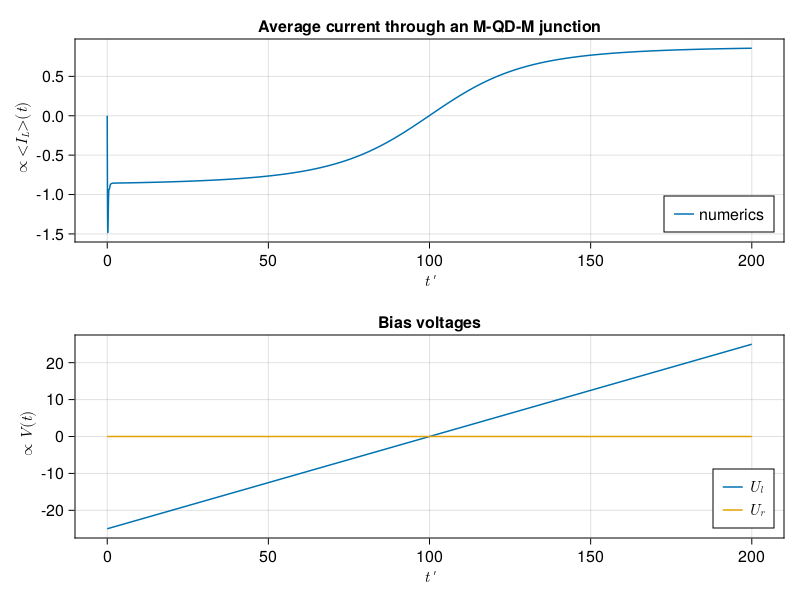

In [7]:
using QuadGK
Tmax = 200
Vmax = 50
Ur(t) = 0
Ul(t) = Vmax * (t / Tmax - 1 // 2)
δt = 0.1 * 2π / Vmax
@show δt
p = Junction.Parameters(
    δt=δt,
    T=Tmax,
    ϕl=t -> quadgk(Ul, 0, t)[1],
    ϕr=t -> quadgk(Ur, 0, t)[1]
)
println("N = $(Junction.axis(p)|> length)")
results = Junction.simulate_junction(p, cpr=HssCompression());
iavr = Junction.compute_average_current(results)
function plot_results(iavr,Ul,Ur)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title="Average current through an M-QD-M junction", xlabel=L"t'", ylabel=L"\propto <I_L>(t)")
    ax = Junction.axis(p) |> collect
    lines!(f_ax, ax, real.(iavr),label  = "numerics")

    axislegend(position = :rb)
    #Bias
    f_ax = Axis(f[2, 1], title="Bias voltages", xlabel=L"t'", ylabel=L"\propto V(t)")
    ax = Junction.axis(p) |> collect
    lines!(f_ax, ax, Ul.(ax),label = L"U_l")
    lines!(f_ax, ax, Ur.(ax),label = L"U_r")
    axislegend(position = :rb)
    f
end
f = plot_results(iavr,Ul,Ur)
save("average_current_QD.svg",f)
f
